# expiMap

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 05.01.2023
- **Date of Last Modification:** 21.08.2023

- The expiMap source code is available at https://github.com/theislab/scarches.
- The corresponding preprint is "Lotfollahi, M. et al. Biologically informed deep learning to infer gene program activity in single cells. bioRxiv 2022.02.05.479217 (2022) doi:10.1101/2022.02.05.479217".
- The workflow of this notebook follows the tutorial from https://scarches.readthedocs.io/en/latest/expimap_surgery_pipeline_basic.html.
- We use a modified version of the NicheCompass gene program mask with only target genes as the gene program mask for expimap. The reasons are that it is relevant for cell communication, to improve comparability and since the expiMap method did not work well on this dataset with the reactome gene program used in the above cited tutorial.
- The authors use raw counts as input to expiMap. Therefore, we also use raw counts (stored in adata.X).

## 1. Setup

### 1.1 Import Libraries

In [1]:
import os
import time
from datetime import datetime

import gdown
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import scarches as sca
import scipy.sparse as sp
import squidpy as sq
from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                extract_gp_dict_from_mebocost_es_interactions,
                                extract_gp_dict_from_nichenet_lrt_interactions,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps)

[rank: 0] Global seed set to 0
/home/aih/sebastian.birk/.local/lib/python3.9/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/aih/sebastian.birk/.local/lib/python3.9/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


### 1.2 Define Parameters

In [2]:
model_name = "expimap"
latent_key = f"{model_name}_latent"
leiden_resolution = 0.5 # used for Leiden clustering of latent space
random_seed = 0 # used for Leiden clustering

### 1.3 Run Notebook Setup

In [3]:
sc.set_figure_params(figsize=(6, 6))

In [4]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths and Directories

In [5]:
data_folder_path = "../../datasets/srt_data/gold/"
benchmarking_folder_path = "../../artifacts/single_sample_method_benchmarking"
figure_folder_path = f"../../figures"
gp_data_folder_path = "../../datasets/gp_data" # gene program data
ga_data_folder_path = "../../datasets/ga_data" # gene annotation data

# Create required directories
os.makedirs(gp_data_folder_path, exist_ok=True)

## 2. expiMap Model

### 2.1 Prepare Gene Program Mask

#### 2.1.1 Mouse

In [6]:
species = "mouse"

nichenet_lr_network_file_path = gp_data_folder_path + \
                                "/nichenet_lr_network_v2_" \
                                f"{species}.csv"
nichenet_ligand_target_matrix_file_path = gp_data_folder_path + \
                                          "/nichenet_ligand_target_matrix_" \
                                          f"v2_{species}.csv"
omnipath_lr_network_file_path = gp_data_folder_path + \
                                     "/omnipath_lr_network.csv"
gene_orthologs_mapping_file_path = ga_data_folder_path + \
                                   "/human_mouse_gene_orthologs.csv"

print("\nPreparing the gene program mask...")
# OmniPath gene programs
mouse_omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    species=species,
    min_curation_effort=0,
    load_from_disk=True,
    save_to_disk=False,
    lr_network_file_path=omnipath_lr_network_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=False)

# NicheNet gene programs
mouse_nichenet_gp_dict = extract_gp_dict_from_nichenet_lrt_interactions(
    species=species,
    version="v2",
    keep_target_genes_ratio=1.0,
    max_n_target_genes_per_gp=250,
    load_from_disk=True,
    save_to_disk=False,
    lr_network_file_path=nichenet_lr_network_file_path,
    ligand_target_matrix_file_path=nichenet_ligand_target_matrix_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=False)

# Combine gene programs into one dictionary
mouse_combined_gp_dict = dict(mouse_omnipath_gp_dict)
mouse_combined_gp_dict.update(mouse_nichenet_gp_dict)

mouse_mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    dir_path=f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps",
    species=species,
    plot_gp_gene_count_distributions=False)

mouse_combined_gp_dict.update(mouse_mebocost_gp_dict)
    
# Filter and combine gene programs
mouse_combined_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=mouse_combined_gp_dict,
    gp_filter_mode="subset",
    combine_overlap_gps=True,
    overlap_thresh_source_genes=0.9,
    overlap_thresh_target_genes=0.9,
    overlap_thresh_genes=0.9,
    verbose=False)

print("Number of gene programs before filtering and combining: "
      f"{len(mouse_combined_new_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: "
      f"{len(mouse_combined_new_gp_dict)}.")


Preparing the gene program mask...
Number of gene programs before filtering and combining: 1818.
Number of gene programs after filtering and combining: 1818.


#### 2.1.2 Human

In [ ]:
species = "human"

nichenet_lr_network_file_path = gp_data_folder_path + \
                                "/nichenet_lr_network_v2_" \
                                f"{species}.csv"
nichenet_ligand_target_matrix_file_path = gp_data_folder_path + \
                                          "/nichenet_ligand_target_matrix_" \
                                          f"v2_{species}.csv"
omnipath_lr_network_file_path = gp_data_folder_path + \
                                     "/omnipath_lr_network.csv"
gene_orthologs_mapping_file_path = ga_data_folder_path + \
                                   "/human_mouse_gene_orthologs.csv"

print("\nPreparing the gene program mask...")
# OmniPath gene programs
human_omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    species=species,
    min_curation_effort=0,
    load_from_disk=True,
    save_to_disk=False,
    lr_network_file_path=omnipath_lr_network_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=False)

# NicheNet gene programs
human_nichenet_gp_dict = extract_gp_dict_from_nichenet_lrt_interactions(
    species=species,
    version="v2",
    keep_target_genes_ratio=1.0,
    max_n_target_genes_per_gp=250,
    load_from_disk=True,
    save_to_disk=False,
    lr_network_file_path=nichenet_lr_network_file_path,
    ligand_target_matrix_file_path=nichenet_ligand_target_matrix_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=False)

# Combine gene programs into one dictionary
human_combined_gp_dict = dict(human_omnipath_gp_dict)
human_combined_gp_dict.update(human_nichenet_gp_dict)

human_mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    dir_path=f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps",
    species=species,
    plot_gp_gene_count_distributions=False)

human_combined_gp_dict.update(human_mebocost_gp_dict)
    
# Filter and combine gene programs
human_combined_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=human_combined_gp_dict,
    gp_filter_mode="subset",
    combine_overlap_gps=True,
    overlap_thresh_source_genes=0.9,
    overlap_thresh_target_genes=0.9,
    overlap_thresh_genes=0.9,
    verbose=False)

print("Number of gene programs before filtering and combining: "
      f"{len(human_combined_new_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: "
      f"{len(human_combined_new_gp_dict)}.")

### 2.2 Define Training Function

In [10]:
def train_expimap_models(dataset,
                         gp_dict,
                         cell_type_key,
                         adata_new=None,
                         n_start_run=1,
                         n_end_run=8,
                         n_neighbor_list=[4, 4, 8, 8, 12, 12, 16, 16],
                         plot_latent_umaps: bool=False):
    
    # Configure figure folder path
    dataset_figure_folder_path = f"{figure_folder_path}/{dataset}/method_benchmarking/expimap/{current_timestamp}"
    os.makedirs(dataset_figure_folder_path, exist_ok=True)
    
    # Create new adata to store results from training runs in storage-efficient way
    if adata_new is None:
        adata_original = sc.read_h5ad(data_folder_path + f"{dataset}.h5ad")
        adata_new = sc.AnnData(sp.csr_matrix(
            (adata_original.shape[0], adata_original.shape[1]),
            dtype=np.float32))
        adata_new.var_names = adata_original.var_names
        adata_new.obs_names = adata_original.obs_names
        adata_new.obs["cell_type"] = adata_original.obs[cell_type_key].values
        adata_new.obsm["spatial"] = adata_original.obsm["spatial"]
        del(adata_original)
    
    model_seeds = list(range(10))
    for run_number, n_neighbors in zip(np.arange(n_start_run, n_end_run+1), n_neighbor_list):
        # n_neighbors is here only used for the latent neighbor graph construction used for
        # UMAP generation and clustering as expiMap is not a spatial method
        
        # Load data
        adata = sc.read_h5ad(data_folder_path + f"{dataset}.h5ad")
        
        # Store raw counts in optimized format in adata.X
        adata.layers["counts"] = adata.layers["counts"].tocsr()
        adata.X = adata.layers["counts"]
        
        adata.obs["batch"] == "batch1"  
        
        # Add the gene program dictionary as binary masks to the adata for model training
        # Use only target genes from the NicheCompass gene program mask
        add_gps_from_gp_dict_to_adata(
            gp_dict=gp_dict,
            adata=adata,
            genes_uppercase=True,
            gp_targets_mask_key="I",
            gp_sources_mask_key="_",
            gp_names_key="terms",
            min_genes_per_gp=1,
            min_source_genes_per_gp=0,
            min_target_genes_per_gp=0,
            max_genes_per_gp=None,
            max_source_genes_per_gp=None,
            max_target_genes_per_gp=None)

        # Determine dimensionality of hidden encoder
        n_hidden_encoder = len(adata.uns["terms"])
        
        start_time = time.time()
        
        # Initialize model
        intr_cvae = sca.models.EXPIMAP(adata=adata,
                                       condition_key="batch",
                                       hidden_layer_sizes=[256, 256, 256],
                                       recon_loss="nb")

        # Train model
        early_stopping_kwargs = {
            "early_stopping_metric": "val_unweighted_loss",
            "threshold": 0,
            "patience": 50,
            "reduce_lr": True,
            "lr_patience": 13,
            "lr_factor": 0.1}
        intr_cvae.train(
            n_epochs=400,
            alpha_epoch_anneal=100,
            alpha=0.7,
            alpha_kl=0.01,
            weight_decay=0.,
            early_stopping_kwargs=early_stopping_kwargs,
            use_early_stopping=True,
            monitor_only_val=False,
            seed=model_seeds[run_number-1])

        # Store latent representation
        adata.obsm[latent_key] = intr_cvae.get_latent(mean=False, only_active=True)
        
        # Measure time for model training
        end_time = time.time()
        elapsed_time = end_time - start_time
        hours, rem = divmod(elapsed_time, 3600)
        minutes, seconds = divmod(rem, 60)
        print(f"Duration of model training in run {run_number}: {int(hours)} hours, {int(minutes)} minutes and {int(seconds)} seconds.")
        adata_new.uns[f"{model_name}_model_training_duration_run{run_number}"] = (
            elapsed_time)

        if plot_latent_umaps:
            # Use expiMap latent space for UMAP generation
            sc.pp.neighbors(adata,
                            use_rep=latent_key,
                            n_neighbors=n_neighbors)
            sc.tl.umap(adata)
            fig = sc.pl.umap(adata,
                             color=[cell_type_key],
                             title="Latent Space with Cell Types: expiMap",
                             return_fig=True)
            fig.savefig(f"{dataset_figure_folder_path}/latent_{model_name}"
                        f"_cell_types_run{run_number}.png",
                        bbox_inches="tight")

            # Compute latent Leiden clustering
            sc.tl.leiden(adata=adata,
                         resolution=leiden_resolution,
                         random_state=random_seed,
                         key_added=f"latent_{model_name}_leiden_{str(leiden_resolution)}")

            # Create subplot of latent Leiden cluster annotations in physical and latent space
            fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 12))
            title = fig.suptitle(t="Latent and Physical Space with Leiden Clusters: expiMap")
            sc.pl.umap(adata=adata,
                       color=[f"latent_{model_name}_leiden_{str(leiden_resolution)}"],
                       title=f"Latent Space with Leiden Clusters",
                       ax=axs[0],
                       show=False)
            sq.pl.spatial_scatter(adata=adata,
                                  color=[f"latent_{model_name}_leiden_{str(leiden_resolution)}"],
                                  title=f"Physical Space with Leiden Clusters",
                                  shape=None,
                                  ax=axs[1])

            # Create and position shared legend
            handles, labels = axs[0].get_legend_handles_labels()
            lgd = fig.legend(handles, labels, bbox_to_anchor=(1.25, 0.9185))
            axs[0].get_legend().remove()
            axs[1].get_legend().remove()

            # Adjust, save and display plot
            plt.subplots_adjust(wspace=0, hspace=0.2)
            fig.savefig(f"{dataset_figure_folder_path}/latent_physical_comparison_"
                        f"{model_name}_run{run_number}.png",
                        bbox_extra_artists=(lgd, title),
                        bbox_inches="tight")
            plt.show()

        # Store latent representation
        adata_new.obsm[latent_key + f"_run{run_number}"] = adata.obsm[latent_key]

        # Store intermediate adata to disk
        adata_new.write(f"{benchmarking_folder_path}/{dataset}_{model_name}5.h5ad")

    # Store final adata to disk
    adata_new.write(f"{benchmarking_folder_path}/{dataset}_{model_name}5.h5ad")    

### 2.3 Train Models on Benchmarking Datasets

In [ ]:
train_expimap_models(dataset="seqfish_mouse_organogenesis_embryo2",
                     gp_dict=mouse_combined_new_gp_dict,
                     cell_type_key="celltype_mapped_refined",
                     adata_new=None,
                     n_start_run=1,
                     n_end_run=8,
                     n_neighbor_list=[4, 4, 8, 8, 12, 12, 16, 16])

In [ ]:
for subsample_pct in [50, 25, 10, 5, 1]:
    train_expimap_models(dataset=f"seqfish_mouse_organogenesis_subsample_{subsample_pct}pct_embryo2",
                         gp_dict=mouse_combined_new_gp_dict,
                         cell_type_key="celltype_mapped_refined",
                         adata_new=None,
                         n_start_run=1,
                         n_end_run=8,
                         n_neighbor_list=[4, 4, 8, 8, 12, 12, 16, 16])

In [ ]:
train_expimap_models(dataset="nanostring_cosmx_human_nsclc_batch5",
                     gp_dict=human_combined_new_gp_dict,
                     cell_type_key="cell_type",
                     adata_new=None,
                     n_start_run=1,
                     n_end_run=8,
                     n_neighbor_list=[4, 4, 8, 8, 12, 12, 16, 16])

In [ ]:
for subsample_pct in [50, 25, 10, 5, 1]:
    train_expimap_models(dataset=f"nanostring_cosmx_human_nsclc_subsample_{subsample_pct}pct_batch5",
                         gp_dict=human_combined_new_gp_dict,
                         cell_type_key="cell_type",
                         adata_new=None,
                         n_start_run=1,
                         n_end_run=8,
                         n_neighbor_list=[4, 4, 8, 8, 12, 12, 16, 16])

In [ ]:
train_expimap_models(dataset="vizgen_merfish_mouse_liver",
                     gp_dict=mouse_combined_new_gp_dict,
                     cell_type_key="Cell_Type",
                     adata_new=None,
                     n_start_run=1,
                     n_end_run=8,
                     n_neighbor_list=[4, 4, 8, 8, 12, 12, 16, 16])

In [ ]:
for subsample_pct in [50, 25, 10, 5, 1]:
    train_expimap_models(dataset=f"vizgen_merfish_mouse_liver_subsample_{subsample_pct}pct",
                         cell_type_key="Cell_Type",
                         gp_dict=mouse_combined_new_gp_dict,
                         adata_new=None,
                         n_start_run=1,
                         n_end_run=8,
                         n_neighbor_list=[4, 4, 8, 8, 12, 12, 16, 16])

In [14]:
adata

AnnData object with n_obs × n_vars = 41786 × 4000
    obs: 'cell_type', 'sample', 'run1_leiden_1.0'
    uns: 'expimap_model_training_duration_run1', 'expimap_latent_run1', 'umap', 'leiden', 'run1_leiden_1.0_colors'
    obsm: 'expimap_latent_run1', 'spatial', 'X_umap'
    obsp: 'expimap_latent_run1_distances', 'expimap_latent_run1_connectivities'

In [15]:
train_expimap_models(dataset="slideseqv2_mouse_hippocampus",
                     cell_type_key="cell_type",
                     gp_dict=mouse_combined_new_gp_dict,
                     adata_new=adata,
                     n_start_run=2,
                     n_end_run=2,
                     n_neighbor_list=[4])


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 4000 256 1
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 1519
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  1519 0 0 1 4000
	with hard mask.
Last Decoder layer: softmax
Preparing (41786, 4000)
Instantiating dataset
Init the group lasso proximal operator for the main terms.
 |████████------------| 42.0%  - epoch_loss: 209.4566391925 - epoch_recon_loss: 202.9349773692 - epoch_kl_loss: 652.1662084878 - val_loss: 146.1795608058 - val_recon_loss: 139.8414940112 - val_kl_loss: 633.8067589962790
ADJUSTED LR
 |█████████-----------| 45.2%  - epoch_loss: 208.3453138183 - epoch_recon_loss: 201.8156197996 - epoch_kl_loss: 652.9694421470 - val_loss: 145.3632086552 - val_recon_loss: 139.0451368852 - val_kl_loss: 631.8071326054
ADJUSTED LR
 |█████████-----------| 48.5%  - epoch_loss: 208.7534170345 - epoch_recon_loss: 202.2281990830 - epoc

In [17]:
adata = sc.read_h5ad("../../artifacts/single_sample_method_benchmarking/slideseqv2_mouse_hippocampus_expimap5.h5ad")

In [22]:
adata

AnnData object with n_obs × n_vars = 41786 × 4000
    obs: 'cell_type', 'sample', 'run1_leiden_1.0'
    uns: 'expimap_latent_run1', 'expimap_model_training_duration_run1', 'expimap_model_training_duration_run2', 'umap'
    obsm: 'X_umap', 'expimap_latent_run1', 'expimap_latent_run2', 'spatial'
    obsp: 'expimap_latent_run1_connectivities', 'expimap_latent_run1_distances'

In [32]:
adata2 = sc.read_h5ad("../../artifacts/single_sample_method_benchmarking/slideseqv2_mouse_hippocampus_expimap2.h5ad")

In [33]:
adata2

AnnData object with n_obs × n_vars = 41786 × 4000
    obs: 'cell_type'
    uns: 'expimap_model_training_duration_run7', 'expimap_model_training_duration_run8'
    obsm: 'expimap_latent_run7', 'expimap_latent_run8', 'spatial'

In [34]:
for run_number in [7, 8]:
    adata.uns[f"expimap_model_training_duration_run{run_number}"] = adata2.uns[f"expimap_model_training_duration_run{run_number}"]
    adata.obsm[f"expimap_latent_run{run_number}"] = adata2.obsm[f"expimap_latent_run{run_number}"]

In [36]:
del(adata.uns["expimap_latent_run1"])

In [38]:
adata.write("../../artifacts/single_sample_method_benchmarking/slideseqv2_mouse_hippocampus_expimap.h5ad")

In [12]:
import sys
sys.path.append("../../utils")
from analysis_utils import (add_cell_type_latent_cluster_emphasis,
                            add_sub_cell_type,
                            compute_cell_type_latent_clusters,
                            generate_gp_info_plots,
                            plot_physical_latent_for_cell_types,
                            plot_cell_type_latent_clusters,
                            plot_latent,
                            plot_category_in_latent_and_physical_space,
                            store_top_gps_summary)
from nichecompass.utils import create_new_color_dict
from benchmarking_utils import *

In [39]:
train_expimap_models(dataset="slideseqv2_mouse_hippocampus_subsample_10pct",
                     cell_type_key="cell_type",
                     gp_dict=mouse_combined_new_gp_dict,
                     adata_new=None,
                     n_start_run=1,
                     n_end_run=8,
                     n_neighbor_list=[4, 4, 8, 8, 12, 12, 16, 16])


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 4000 256 1
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 1519
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  1519 0 0 1 4000
	with hard mask.
Last Decoder layer: softmax
Preparing (4200, 4000)
Instantiating dataset
Init the group lasso proximal operator for the main terms.
 |█████████-----------| 45.0%  - epoch_loss: 207.9311086019 - epoch_recon_loss: 199.5809570312 - epoch_kl_loss: 835.0151631673 - val_loss: 175.3314285278 - val_recon_loss: 167.8944549561 - val_kl_loss: 743.697158813562
ADJUSTED LR
 |█████████-----------| 48.2%  - epoch_loss: 205.7182744344 - epoch_recon_loss: 197.3225301107 - epoch_kl_loss: 839.5744303385 - val_loss: 173.9829711914 - val_recon_loss: 166.5993881226 - val_kl_loss: 738.3585510254
ADJUSTED LR
 |██████████----------| 51.5%  - epoch_loss: 207.9541412354 - epoch_recon_loss: 199.6258102417 - epoch_

In [40]:
train_expimap_models(dataset="slideseqv2_mouse_hippocampus_subsample_5pct",
                     cell_type_key="cell_type",
                     gp_dict=mouse_combined_new_gp_dict,
                     adata_new=None,
                     n_start_run=1,
                     n_end_run=8,
                     n_neighbor_list=[4, 4, 8, 8, 12, 12, 16, 16])


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 4000 256 1
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 1519
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  1519 0 0 1 4000
	with hard mask.
Last Decoder layer: softmax
Preparing (2098, 4000)
Instantiating dataset
Init the group lasso proximal operator for the main terms.
 |███████-------------| 38.2%  - epoch_loss: 225.5028106689 - epoch_recon_loss: 215.8420379639 - epoch_kl_loss: 966.0773437500 - val_loss: 202.5481338501 - val_recon_loss: 194.3114166260 - val_kl_loss: 823.671691894511
ADJUSTED LR
 |████████------------| 41.5%  - epoch_loss: 226.1387674967 - epoch_recon_loss: 216.4665395101 - epoch_kl_loss: 967.2228841146 - val_loss: 200.0128097534 - val_recon_loss: 191.7855300903 - val_kl_loss: 822.7283325195
ADJUSTED LR
 |█████████-----------| 45.0%  - epoch_loss: 224.2523305257 - epoch_recon_loss: 214.5959147135 - epoch_

In [41]:
train_expimap_models(dataset="slideseqv2_mouse_hippocampus_subsample_1pct",
                     cell_type_key="cell_type",
                     gp_dict=mouse_combined_new_gp_dict,
                     adata_new=None,
                     n_start_run=1,
                     n_end_run=8,
                     n_neighbor_list=[4, 4, 8, 8, 12, 12, 16, 16])


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 4000 256 1
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 1519
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  1519 0 0 1 4000
	with hard mask.
Last Decoder layer: softmax
Preparing (388, 4000)
Instantiating dataset
Init the group lasso proximal operator for the main terms.
 |██████████----------| 54.5%  - epoch_loss: 259.5074106852 - epoch_recon_loss: 247.6303405762 - epoch_kl_loss: 1187.7066243490 - val_loss: 238.1615447998 - val_recon_loss: 228.5384979248 - val_kl_loss: 962.30529785163
ADJUSTED LR
 |███████████---------| 58.2%  - epoch_loss: 258.4880523682 - epoch_recon_loss: 246.5744578044 - epoch_kl_loss: 1191.3597819010 - val_loss: 237.7190093994 - val_recon_loss: 228.0295867920 - val_kl_loss: 968.9425659180
ADJUSTED LR
 |████████████--------| 61.5%  - epoch_loss: 258.6541239421 - epoch_recon_loss: 246.8981628418 - epoch_


Computing neighbor graph...

Computing UMAP embedding...

Computing Leiden clustering...


/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


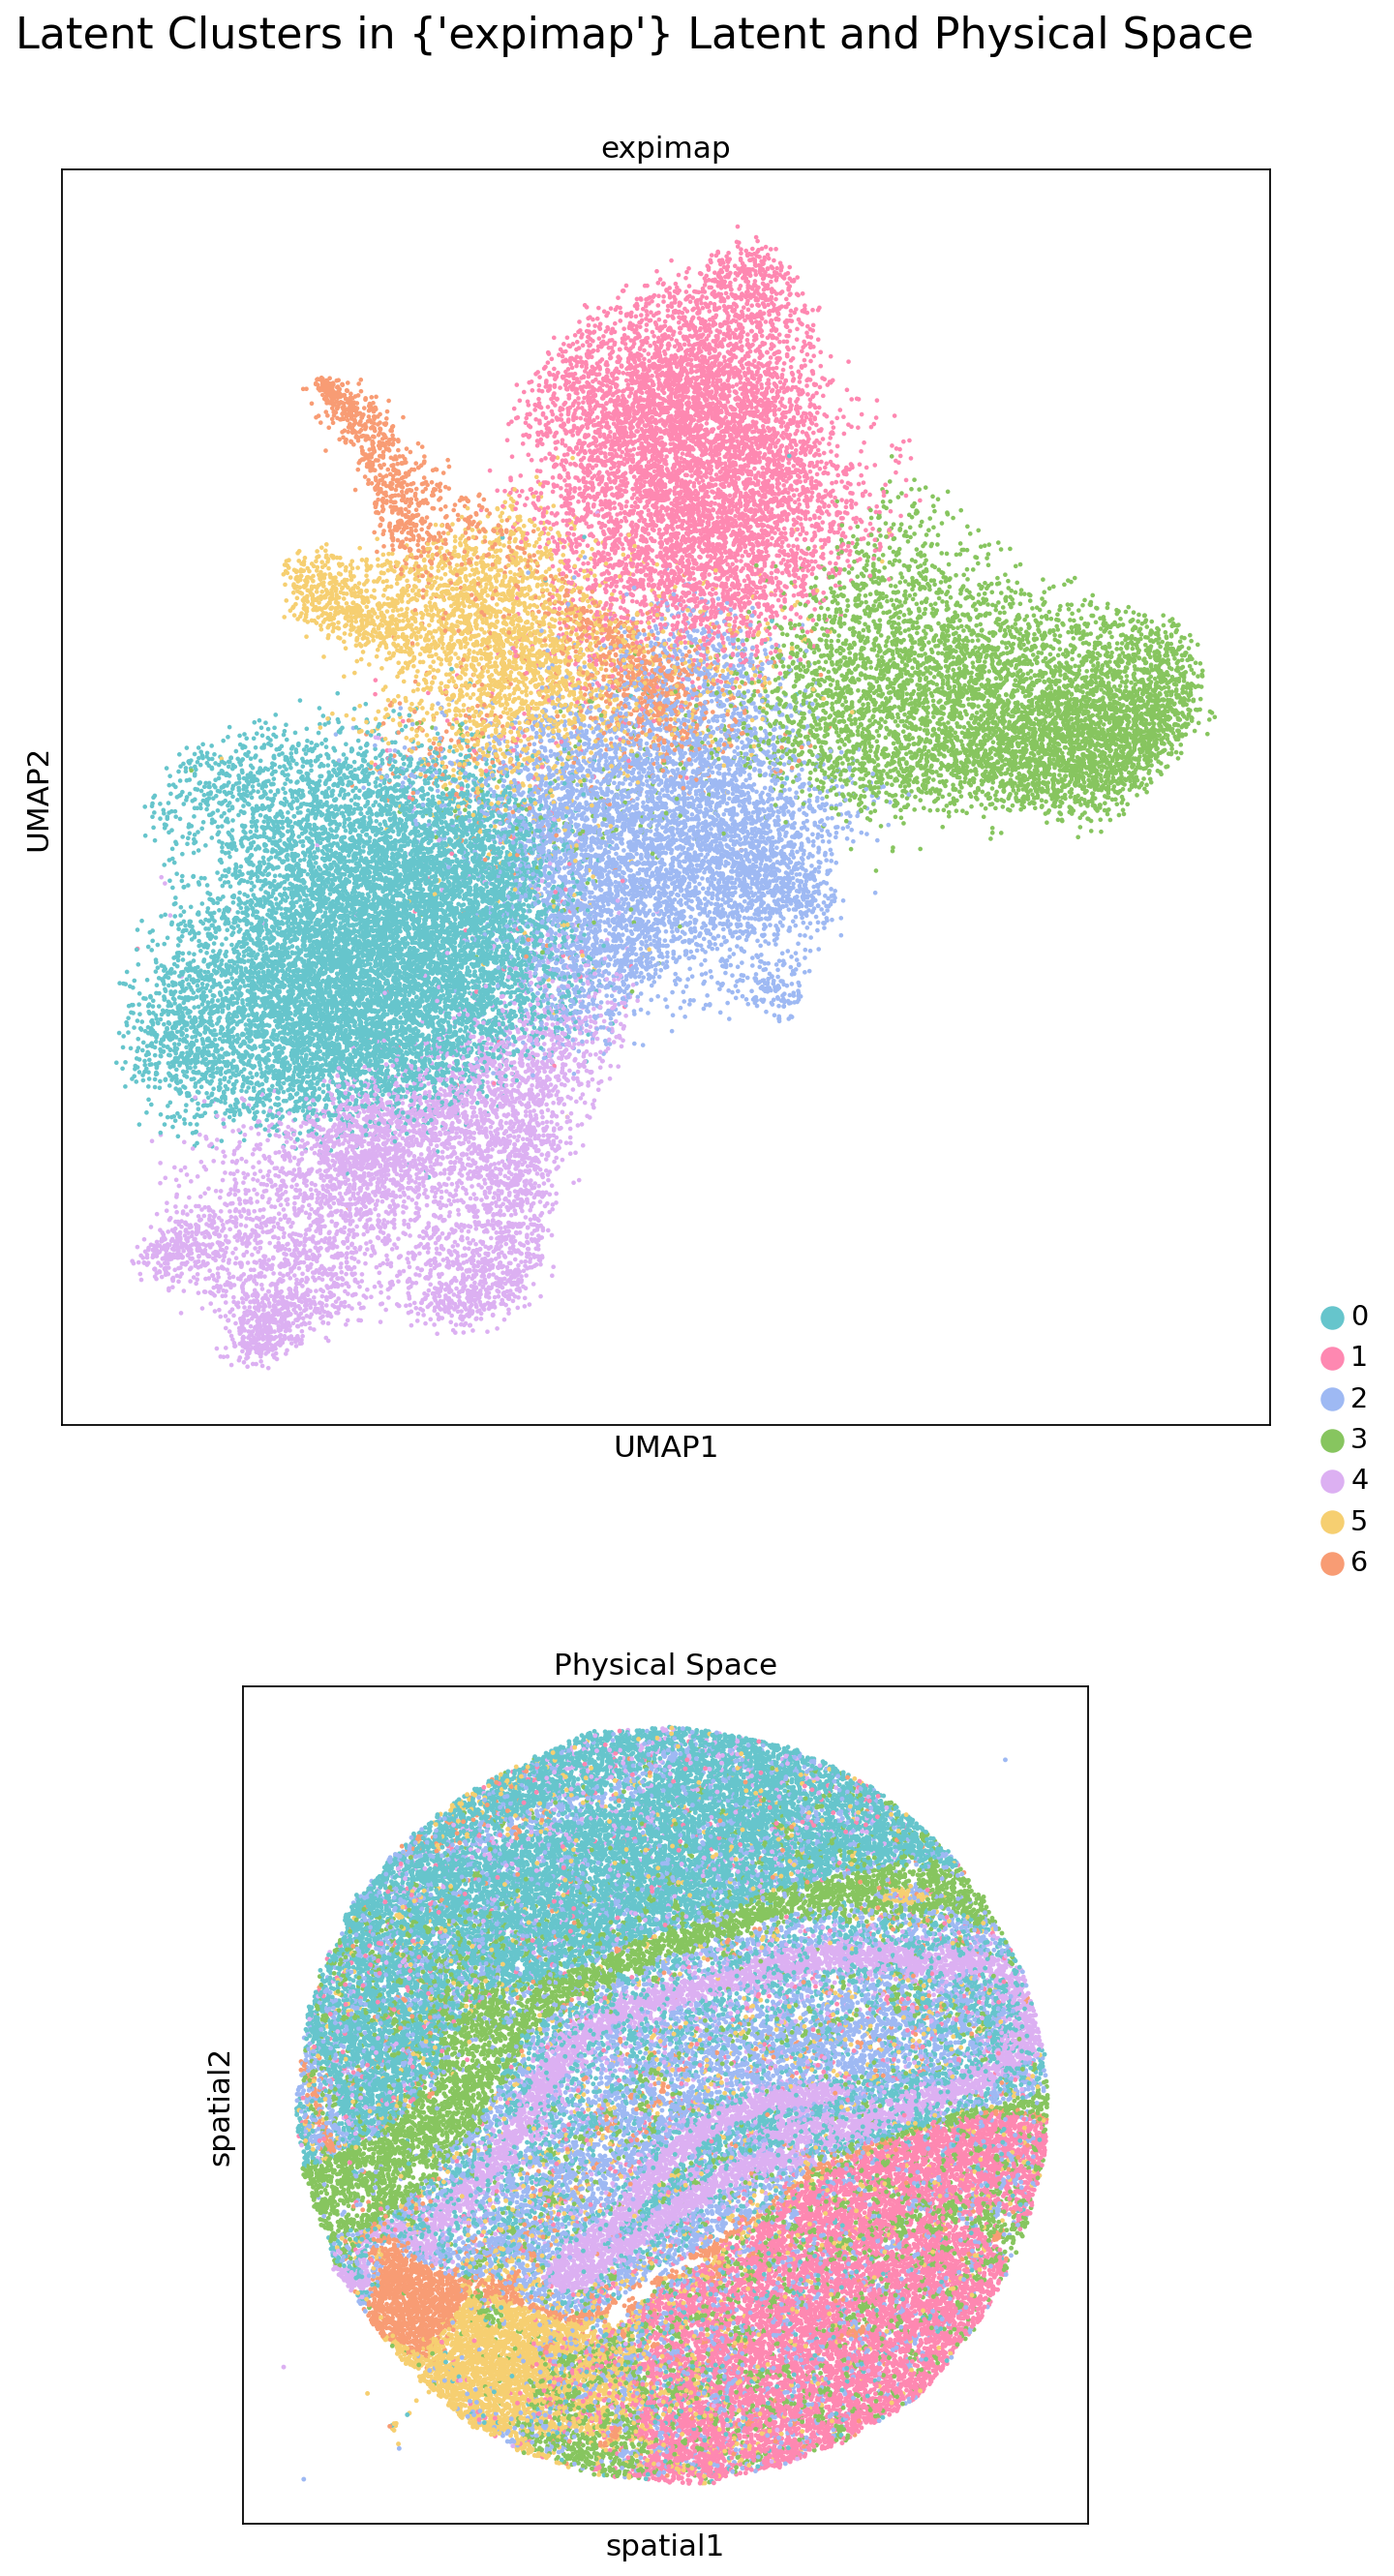

In [13]:


adata = sc.read_h5ad("../../artifacts/single_sample_method_benchmarking/slideseqv2_mouse_hippocampus_expimap5.h5ad")

model = "expimap"
run_number = 1
leiden_resolution = 1.0

adata.obs["sample"] = "sample1"

print("\nComputing neighbor graph...")
# Use latent representation for UMAP generation
sc.pp.neighbors(adata,
                use_rep=f"{model}_latent_run{run_number}",
                key_added=f"{model}_latent_run{run_number}")

print("\nComputing UMAP embedding...")
sc.tl.umap(adata,
           neighbors_key=f"{model}_latent_run{run_number}")

print("\nComputing Leiden clustering...")
sc.tl.leiden(adata=adata,
             resolution=leiden_resolution,
             key_added=f"run{run_number}_leiden_{leiden_resolution}",
             neighbors_key=f"{model}_latent_run{run_number}")

latent_cluster_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"run{run_number}_leiden_{leiden_resolution}")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Latent Clusters",
        model_label={model},
        cat_key=f"run{run_number}_leiden_{leiden_resolution}",
        groups=None,
        sample_key="sample",
        samples=["sample1"],
        cat_colors=latent_cluster_colors,
        size=(720000 / len(adata)),
        spot_size=30,
        save_fig=False,
        file_path=f"{benchmarking_folder_path}/latent_clusters_{model}.svg")

In [ ]:
for subsample_pct in [50, 25, 10, 5, 1]:
    train_expimap_models(dataset=f"slideseqv2_mouse_hippocampus_subsample_{subsample_pct}pct",
                         cell_type_key="cell_type",
                         gp_dict=mouse_combined_new_gp_dict,
                         adata_new=None,
                         n_start_run=1,
                         n_end_run=8,
                         n_neighbor_list=[4, 4, 8, 8, 12, 12, 16, 16])